In [3]:
# Necessary Imports

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split, KFold, cross_val_score,
                                     RandomizedSearchCV, TimeSeriesSplit)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load dataset
train = pd.read_csv('train.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
test = pd.read_csv('test.csv')
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [6]:
stores = pd.read_csv('stores.csv')
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
features = pd.read_csv('features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
print("Train Shape:-", train.shape)
print("Test Shape:-", test.shape)
print("Stores Shape:-", stores.shape)
print("Features Shape:-", features.shape)

Train Shape:- (421570, 5)
Test Shape:- (115064, 4)
Stores Shape:- (45, 3)
Features Shape:- (8190, 12)


In [9]:
# Peek at columns

print(train.columns.tolist())
print(features.columns.tolist())
print(stores.columns.tolist())

['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
['Store', 'Type', 'Size']


In [10]:
# Drop duplicate IsHoliday in features 
features = features.drop('IsHoliday', axis=1)

In [11]:

# Merge train data: left-join to keep all train rows
train_data = train.merge(features, on=['Store','Date'], how='left') \
                  .merge(stores, on='Store', how='left')

In [12]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [13]:
# Merge test data similarly (for final predictions)
test_data = test.merge(features, on=['Store','Date'], how='left') \
                .merge(stores, on='Store', how='left')


In [14]:
test_data.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315


In [15]:
print("Merged train shape:", train_data.shape)
print("Merged test shape:", test_data.shape)

Merged train shape: (421570, 16)
Merged test shape: (115064, 15)


In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [17]:
# Convert Date to datetime for feature extraction

train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] =pd.to_datetime(test_data['Date'])

In [18]:
train_data.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [19]:
# Fill missing values in Markdowns with 0 (No promotions)

md_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for col in md_cols:
    if col in train_data.columns:
        train_data[col].fillna(0, inplace=True)
        test_data[col].fillna(0, inplace=True)

In [20]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


# EDA 

<Axes: title={'center': 'Total Weekly Sales Over Time'}, xlabel='Date'>

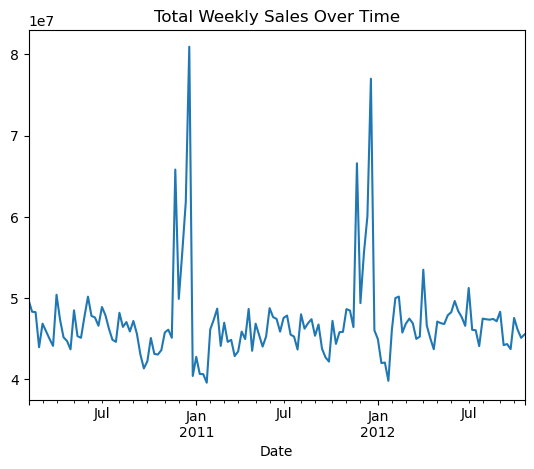

In [21]:
# Total weekly sales across all stores/depts

weekly_sales = train_data.groupby('Date')['Weekly_Sales'].sum().reset_index()
weekly_sales.set_index('Date', inplace=True)
weekly_sales['Weekly_Sales'].plot(title='Total Weekly Sales Over Time')

In [22]:
# Average weekly sales for holiday vs non-holiday weeks

holiday_sales = train_data.groupby('IsHoliday')['Weekly_Sales'].mean()
print("Mean sales (IsHoliday=0):", holiday_sales.iloc[0])
print("Mean sales (IsHoliday=1):", holiday_sales.iloc[1])

Mean sales (IsHoliday=0): 15901.445069008367
Mean sales (IsHoliday=1): 17035.823187350394


Type
A    20099.568043
B    12237.075977
C     9519.532538
Name: Weekly_Sales, dtype: float64


<Axes: title={'center': 'Average Weekly Sales by Store Type'}, xlabel='Type'>

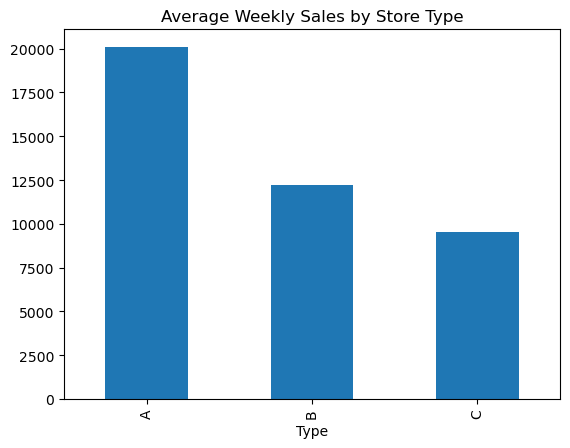

In [23]:
# Average sales by store Type
sales_by_type = train_data.groupby('Type')['Weekly_Sales'].mean().sort_values(ascending=False)
print(sales_by_type)
sales_by_type.plot(kind='bar', title='Average Weekly Sales by Store Type')

# Feature Engineering

In [24]:
for df in [train_data, test_data]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek

In [25]:
train_data = pd.get_dummies(train_data, columns=['Type'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Type'], drop_first=True)

In [26]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Size,Year,Month,WeekOfYear,DayOfWeek,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.0,211.096358,8.106,151315,2010,2,5,4,False,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.0,211.242170,8.106,151315,2010,2,6,4,False,False
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,0.0,211.289143,8.106,151315,2010,2,7,4,False,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,0.0,211.319643,8.106,151315,2010,2,8,4,False,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,0.0,211.350143,8.106,151315,2010,3,9,4,False,False


In [27]:
# Prepare features and target

X = train_data.drop(['Weekly_Sales','Date'], axis=1)
y = train_data['Weekly_Sales']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (421570, 19)
Target vector shape: (421570,)


# Modeling and Cross-Validation

In [28]:
# split for validation (80% train, 20% test)
X_train, X_val, y_train,y_val = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Initialize XGBoost regressor
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

# Cross-validation on training set (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, 
                            scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE (train):", -np.mean(cv_scores))

Cross-validated RMSE (train): 6911.1589419069205


In [29]:
# Train and evaluate
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)

# Calculate MSE first, then take the square root for RMSE
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

mae  = mean_absolute_error(y_val, y_pred)
r2   = r2_score(y_val, y_pred)
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE:  {mae:.2f}")
print(f"Validation R^2:   {r2:.3f}")

Validation RMSE: 6799.17
Validation MAE:  3858.33
Validation R^2:   0.911


In [30]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

# Calculate MSE first, then take the square root for RMSE
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")

Random Forest RMSE: 3673.89


# Feature Importance Analysis

In [31]:
# Feature importance from XGBoost
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)
print("Top 10 feature importances:\n", top_features)

Top 10 feature importances:
 Dept          0.262903
Size          0.204226
Type_B        0.143427
MarkDown3     0.072637
Store         0.066629
Month         0.056102
WeekOfYear    0.042788
CPI           0.038003
Type_C        0.034223
IsHoliday     0.026124
dtype: float32


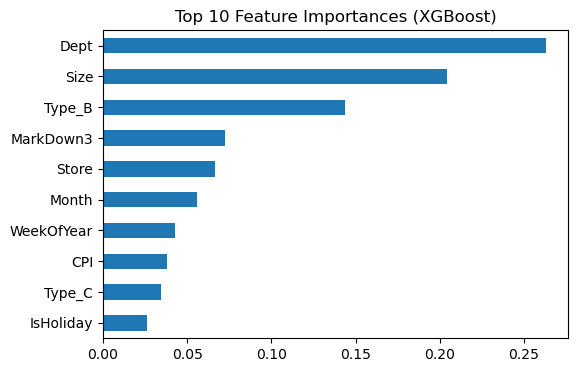

In [32]:
# Visualize importances

top_features.sort_values().plot(kind='barh', figsize=(6,4))
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

# Hyperparameter Tuning Using RandomizedSearchCV and TimeSeriesSplit

In [33]:
# TimeSeries Cross Validator

tscv = TimeSeriesSplit(n_splits=5)

In [34]:
# Define XGB Model and parameter grid

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_iter=25,
    n_jobs=1,  
    verbose=2,
    random_state=42
)

# Fit the XGBoost search
xgb_search.fit(X, y)
print("✅ Best XGBoost Parameters:", xgb_search.best_params_)
print("📉 Best XGBoost CV RMSE:", -xgb_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.4s
[CV] END cols

In [35]:
# Define Random Forest model and parameter grid
rf = RandomForestRegressor(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_iter=20,
    n_jobs=1,
    verbose=2,
    random_state=42
)

# 5. Fit the Random Forest search
rf_search.fit(X, y)
print("✅ Best Random Forest Parameters:", rf_search.best_params_)
print("📉 Best Random Forest CV RMSE:", -rf_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  11.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  24.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  37.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  54.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300; total time= 1.2min
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=  16.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=  35.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=  56.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500; total time= 1.4min
[CV] END max_depth=30, m

In [36]:
#Xgboost best parameters and score
print("✅ Best XGBoost Parameters:", xgb_search.best_params_)
print("📉 Best XGBoost CV RMSE:", -xgb_search.best_score_)

# Random Forest best parameters and score
print("✅ Best Random Forest Parameters:", rf_search.best_params_)
print("📉 Best Random Forest CV RMSE:", -rf_search.best_score_)

✅ Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
📉 Best XGBoost CV RMSE: 11501.432889143447
✅ Best Random Forest Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30}
📉 Best Random Forest CV RMSE: 12122.879958169868


In [48]:
# Final tuned models
xgb_final = XGBRegressor(
    subsample=0.8, n_estimators=500, max_depth=10,
    learning_rate=0.05, colsample_bytree=0.6, random_state=42
)

rf_final  = RandomForestRegressor(
    n_estimators=500, min_samples_split=2,
    max_features='sqrt', max_depth=30, random_state=42
)

# Fit on full training data
xgb_final.fit(X, y)
rf_final.fit(X, y)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=500,
                      random_state=42)

In [43]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Temperature   115064 non-null  float64       
 5   Fuel_Price    115064 non-null  float64       
 6   MarkDown1     115064 non-null  float64       
 7   MarkDown2     115064 non-null  float64       
 8   MarkDown3     115064 non-null  float64       
 9   MarkDown4     115064 non-null  float64       
 10  MarkDown5     115064 non-null  float64       
 11  CPI           76902 non-null   float64       
 12  Unemployment  76902 non-null   float64       
 13  Size          115064 non-null  int64         
 14  Year          115064 non-null  int32         
 15  Month         115

In [41]:
test_data.shape


(115064, 20)

In [44]:
# Fill missing CPI/Unemployment with median (from training set)
test_data['CPI'].fillna(X['CPI'].median(), inplace=True)
test_data['Unemployment'].fillna(X['Unemployment'].median(), inplace=True)

In [46]:
X_test = test_data.drop(['Date'], axis=1)
X_test = X_test[X.columns]  # match training feature order exactly

In [49]:
y_pred_xgb = xgb_final.predict(X_test)
y_pred_rf  = rf_final.predict(X_test)

In [ ]:
# Ensembling 
y_pred_avg = 0.5 * y_pred_xgb + 0.5 * y_pred_rf

In [ ]:
# Prepare final output
output_df = test_data[['Store', 'Dept', 'Date']].copy()
output_df['Predicted_XGB'] = y_pred_xgb
output_df['Predicted_RF'] = y_pred_rf
output_df['Predicted_Ensemble'] = y_pred_avg

# View sample
print(output_df.head())

   Store  Dept       Date  Predicted_XGB  Predicted_RF  Predicted_Ensemble
0      1     1 2012-11-02   32537.251953   27747.41898        30142.335467
1      1     1 2012-11-09   18915.613281   25036.22246        21975.917871
2      1     1 2012-11-16   19924.332031   25249.16846        22586.750246
3      1     1 2012-11-23   19923.431641   29478.38002        24700.905830
4      1     1 2012-11-30   21195.611328   30352.20920        25773.910264


In [52]:
# Save predictions for use
output_df.to_csv('final_sales_predictions.csv', index=False)